#### International Conference on Machine Learning (ICML), 2020.

## Discriminative Jackknife: Quantifying Uncertainty in Deep Learning via Influence Functions

*Ahmed M. Alaa and Mihaela van der Schaar*

### Experiments on synthetic data (Section 5.1)

Import necessary libraries and initialize model parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

from models.static import *
from utils.performance import *  
import pickle

n_epochs     = 100 #1000
n_dim        = 1
activtn      = "Tanh"      
num_hidden   = 100
num_layers   = 2
verbosity    = False
learn_rate   = 0.1

N_EXP = 10

params       = dict({"n_dim":n_dim, 
                     "activation":activtn, 
                     "num_hidden":num_hidden,
                     "num_layers":num_layers})

train_params = dict({"num_iter":n_epochs, 
                     "verbosity":verbosity, 
                     "learning_rate":learn_rate})

Functions for running experiments on synthetic data in various simulation setups.

In [2]:
def true_func(X):
    
    return (X**3)


def sample_data(n_train=50, n_test=20, sigma=3): 
    
    X_train  = np.random.uniform(-4, 4, size=n_train).reshape((-1, 1))

    noise    = np.random.normal(0, sigma**2, size=n_train).reshape((-1, 1))

    Y_train  = true_func(X_train.reshape((-1, 1))) + noise
    
    X_test   = np.linspace(-4, 4, n_test).reshape((-1, 1))
    Y_test   = true_func(X_test).reshape((-1,)) 
    
    return X_train, Y_train, X_test, Y_test


def sweep_noise_vars(coverage=.9):
    
    sigmas   = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    CIs      = []
    Covs     = []
    nexp     = N_EXP

    for _ in range(nexp):
    
        CI  = []
        Cov = []

        for sigma in sigmas:

            X_train, Y_train, X_test, Y_test = sample_data(n_train=1000, n_test=100, sigma=sigma)

            model = DNN(**params)
            model.fit(X_train, Y_train)

            DJ_model                 = DNN_uncertainty_wrapper(model, damp=1e-2)
            y_pred, y_lower, y_upper = DJ_model.predict(X_test, coverage=coverage)
    
            CI.append(np.abs(y_upper - y_lower))
            Cov.append(np.mean(((Y_test >= y_lower) * (Y_test <= y_upper)) * 1))
    
        CIs.append(CI)
        Covs.append(Cov)
    
    return [CIs, Covs]
    

def sweep_num_samples():
    
    n_sample = [10, 100, 1000]
    CIs      = []
    Covs     = []
    nexp     = N_EXP
    coverage = .9

    for _ in range(nexp):
    
        CI  = []
        Cov = []
    
        for n_ in n_sample:

            X_train, Y_train, X_test, Y_test = sample_data(n_train=n_, n_test=100, sigma=1)

            model = DNN(**params)
            model.fit(X_train, Y_train)

            DJ_model                 = DNN_uncertainty_wrapper(model, damp=1e-2)
            y_pred, y_lower, y_upper = DJ_model.predict(X_test, coverage=coverage)
    
            CI.append(np.abs(y_upper - y_lower))
            Cov.append(np.mean(((Y_test >= y_lower) * (Y_test <= y_upper)) * 1))
        
        CIs.append(CI)
        Covs.append(Cov)
    
    return [CIs, Covs]
 

def run_experiments(retrain=True):
    
    if retrain:
        
        res_synth = dict()
        res_synth["nsamples"] = sweep_num_samples()
        res_synth["alpha_50"] = sweep_noise_vars(coverage=.5)
        res_synth["alpha_80"] = sweep_noise_vars(coverage=.8)
        res_synth["alpha_90"] = sweep_noise_vars(coverage=.9)
        
    else:
        
        res_synth = pickle.load(open('saved_models/DJ_Experiment_2_results', 'rb'))
    
    return res_synth

Run the experiments

In [3]:
res_synth = run_experiments()

Average width of confidence intervals for different numbers of training samples **(Figure 4)**

Text(0, 0.5, 'Average width of CIs')

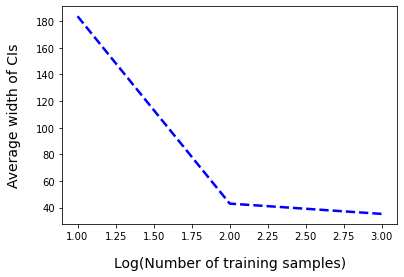

In [4]:
plt.plot([1, 2, 3], np.mean(np.mean(np.array(np.array(res_synth["nsamples"][0])), axis=2), axis=0), 
         linewidth=2.5, linestyle="--", color="b")

# plt.ylim(3, 12)

plt.xlabel("Log(Number of training samples)", fontsize=14, labelpad=15)
plt.ylabel("Average width of CIs", fontsize=14, labelpad=15)

Average width of confidence intervals and achieved coverage for different levels of noise variance **(Figure 4)**

Text(0, 0.5, 'Average width of CIs')

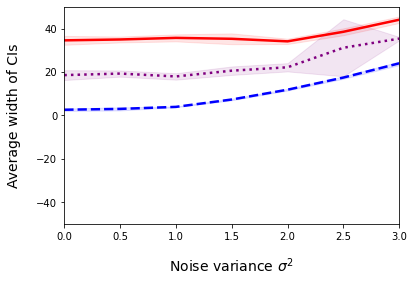

In [7]:
sigmas     = [0, 0.5, 1, 1.5, 2, 2.5, 3]

Mean_CI_50 = np.mean(np.mean(np.array(res_synth["alpha_50"][0]), axis=2), axis=0)
std_CI_50  = np.std(np.mean(np.array(res_synth["alpha_50"][0]), axis=2), axis=0)

Mean_CI_80 = np.mean(np.mean(np.array(res_synth["alpha_80"][0]), axis=2), axis=0)
std_CI_80  = np.std(np.mean(np.array(res_synth["alpha_80"][0]), axis=2), axis=0)

Mean_CI_90 = np.mean(np.mean(np.array(res_synth["alpha_90"][0]), axis=2), axis=0)
std_CI_90  = np.std(np.mean(np.array(res_synth["alpha_90"][0]), axis=2), axis=0)

plt.plot(sigmas, Mean_CI_50, linewidth=2.5, linestyle="--", color="b")
plt.fill_between(sigmas,  Mean_CI_50 - std_CI_50, Mean_CI_50 + std_CI_50, alpha=.1, color="b")

plt.plot(sigmas, Mean_CI_80, linewidth=2.5, linestyle=":", color="purple")
plt.fill_between(sigmas, Mean_CI_80 - std_CI_80, Mean_CI_80 + std_CI_80, alpha=.1, color="purple")

plt.plot(sigmas, Mean_CI_90, linewidth=2.5, color="r")
plt.fill_between(sigmas, Mean_CI_90 - std_CI_90, Mean_CI_90 + std_CI_90, alpha=.1, color="r")

plt.xlim(0, 3)
plt.ylim(-50, 50)

plt.xlabel(r"Noise variance $\sigma^2$", fontsize=14, labelpad=15)
plt.ylabel("Average width of CIs", fontsize=14, labelpad=15)

Text(0, 0.5, 'Achieved Coverage')

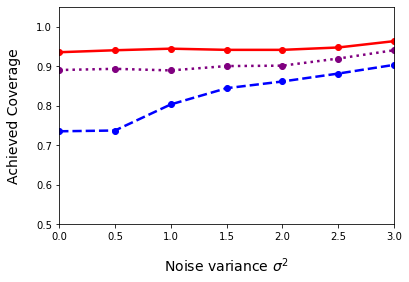

In [6]:
Mean_Cov_50 = np.mean(np.array(res_synth["alpha_50"][1]), axis=0)
Mean_Cov_80 = np.mean(np.array(res_synth["alpha_80"][1]), axis=0)
Mean_Cov_90 = np.mean(np.array(res_synth["alpha_90"][1]), axis=0)

plt.plot(sigmas, Mean_Cov_50, marker="o", linewidth=2.5, linestyle="--", color="b")
plt.plot(sigmas, Mean_Cov_80, marker="o", linewidth=2.5, linestyle=":", color="purple")
plt.plot(sigmas, Mean_Cov_90, marker="o", linewidth=2.5, color="r")

plt.ylim(.5, 1.05)
plt.xlim(0, 3)

plt.xlabel(r"Noise variance $\sigma^2$", fontsize=14, labelpad=15)
plt.ylabel("Achieved Coverage", fontsize=14, labelpad=15)